In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

100%|██████████| 77.1M/77.1M [00:03<00:00, 24.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1


In [ ]:
!pip install nltk

import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import string

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

In [ ]:
data_path = "/root/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1/CEAS_08.csv"

data = pd.read_csv(data_path)


data.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [ ]:
# selecting suitable columns from data
data = data[['subject', 'body', 'label']]

data['contents'] = data['subject'] + " " + data['body']

data = data.drop(['subject', 'body'], axis=1)

data.head()

,label,contents
0,1,"Never agree to be a loser Buck up, your troubl..."
1,1,Befriend Jenna Jameson \nUpgrade your sex and ...
2,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,0,Re: svn commit: r619753 - in /spamassassin/tru...
4,1,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...


In [ ]:
# cleaning the data

data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

data.shape

(39126, 2)

In [ ]:
data.head()

,label,contents
0,1,"Never agree to be a loser Buck up, your troubl..."
1,1,Befriend Jenna Jameson \nUpgrade your sex and ...
2,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,0,Re: svn commit: r619753 - in /spamassassin/tru...
4,1,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...


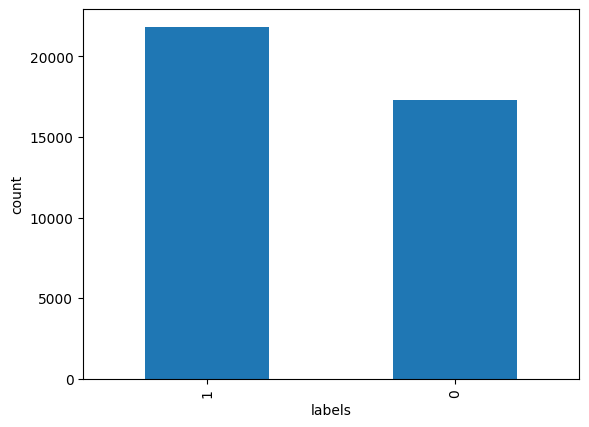

In [ ]:
data['label'].value_counts().plot(kind='bar')
plt.xlabel("labels")
plt.ylabel("count")
plt.show()


In [ ]:
data['contents'].iloc[0]

'Never agree to be a loser Buck up, your troubles caused by small dimension will soon be over!\nBecome a lover no woman will be able to resist!\nhttp://whitedone.com/\n\n\ncome. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.'

In [ ]:
# helper functions

# train test split
def train_val_spilt(data, target):
  x = data.drop(target, axis=1)
  y = data[target]

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

# undersampler function
def handle_imabalance(X_train, X_test, y_train, y_test):
  sampler = RandomUnderSampler(random_state=32)
  X_train_re, y_train_re = sampler.fit_resample(X_train, y_train)
  X_test_re, y_test_re = X_test, y_test

  return X_train_re, X_test_re, y_train_re, y_test_re


# cleaning the contents
def preprocess(text):
  table = str.maketrans("", "", string.punctuation)
  text = text.replace("-", "")
  text = text.split()

  text = [word.lower() for word in text]
  text = [word.translate(table) for word in text]
  text = [word for word in text if len(word) > 1]
  text = [word for word in text if word.isalpha()]
  text = " ".join(text)

  lemmatizer = WordNetLemmatizer()
  words = word_tokenize(text)
  text = [lemmatizer.lemmatize(word, pos='v') for word in words]
  return " ".join(text)

# max length of the content
def get_max_length(data):
  return max([len(text) for text in data.values])

# finding the vocab size
def get_vocab_size(tokenizer):
  return len(tokenizer.word_index) +1

# tokenizign the sequence data
def tokenize_text(data, max_length, tokenizer):
  token_seq = tokenizer.texts_to_sequences(data)
  word_seq = pad_sequences(token_seq, maxlen=max_length, padding="post")
  return word_seq




In [ ]:
# calling the functions

data = data.iloc[:10000]
data['contents'] = data['contents'].apply(preprocess)

max_length = 300

# train test split
X_train, X_test, y_train, y_test = train_val_spilt(data, 'label')
X_train_re, X_test_re, y_train_re, y_test_re = handle_imabalance(X_train, X_test, y_train, y_test)


# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['contents'])
vocab_size = get_vocab_size(tokenizer)


# x y preprocess for train
X_seq_train = tokenize_text(X_train_re['contents'], max_length, tokenizer)


# x and y preprocess for test
X_seq_test = tokenize_text(X_test_re['contents'], max_length, tokenizer)


In [ ]:
X_seq_train

array([[ 2793,    11, 12535, ...,   103,  1644,  1644],
       [    9,   439,  1062, ...,     0,     0,     0],
       [   51,   220,   902, ...,     0,     0,     0],
       ...,
       [  196,  1818,   173, ...,     0,     0,     0],
       [   34,   229,   702, ...,     0,     0,     0],
       [ 1075, 12102,   926, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# model buidling

def create_model(vocab_size, max_length):
  model = Sequential([
      Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length),
      Dropout(0.3),
      LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
      LSTM(64, dropout=0.2, recurrent_dropout=0.2),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = create_model(vocab_size, max_length)

model.fit(X_seq_train, y_train_re, epochs=4, validation_data = (X_seq_test, y_test_re))

Epoch 1/4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


231/231 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.6160 - loss: 0.6327 - val_accuracy: 0.5630 - val_loss: 0.6397
Epoch 2/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.6004 - loss: 0.6289 - val_accuracy: 0.7115 - val_loss: 0.4932
Epoch 3/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7870 - loss: 0.4745 - val_accuracy: 0.9805 - val_loss: 0.0886
Epoch 4/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.9801 - loss: 0.0800 - val_accuracy: 0.9795 - val_loss: 0.0875


In [ ]:
model.save("model.h5")

In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as file:
  pickle.dump(tokenizer, file)

In [ ]:
def predict_fraud(message, tokenizer, max_length):
  message = preprocess(message)
  token = tokenizer.texts_to_sequences([message])
  mesg_seq = pad_sequences(token, maxlen=max_length, padding='post')

  prediction = model.predict(mesg_seq)
  return prediction


predict_fraud(data['contents'].iloc[3], tokenizer, max_length)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


array([[0.00808568]], dtype=float32)

In [ ]:
data[data['label'] == 0].iloc[:10]

,label,contents
3,0,re svn commit in spamassassintrunk libmailspam...
8,0,bug uri process turn uuencoded string into htt...
15,0,re trial irc certificate application plelim ju...
18,0,re opensuse why cant use shutdown now to turn ...
19,0,re fwd opensuse re opensuse box editions steve...
20,0,sciencenow daily email alert sciencenow week i...
21,0,perl overload doesnt handle integer result new...
22,0,wekalist digest vol issue send wekalist mail l...
23,0,spambayescheckins spambayesspambayes update of...
24,0,re opensuse du shx issuequestion greg freemyer...


In [ ]:
data['contents'].iloc[20]

'sciencenow daily email alert sciencenow week in review all free article top last month scienceshots daily news archive about sciencenow all these sciencenow stories and more be available at wwwsciencenoworg thursday february device give new mean to power walkingnew knee brace generate electricity from leg movements kiss cousins sire kid by the dozensrelated couple appear to have reproductive advantage unsubscribe or edit your subscriptions for this service at httpwwwsciencemagorgcgialertsmain write request to unsubscribe may be send to customer service page mill road palo alto ca usa magazine news signal career multimedia collections help site map rss subscribe feedback privacy legal about us advertise with us contact us american association for the advancement of science all right reservedaaas be partner of hinari agora patientinform crossref and counter'